In [144]:
import os
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import pandas as pd
import sqlite3
import sys

conn = sqlite3.connect("database.db")
cur = conn.cursor()

### **Question 1 :** Quel est le profil de consommation moyen d’une journée hors éco-session ?

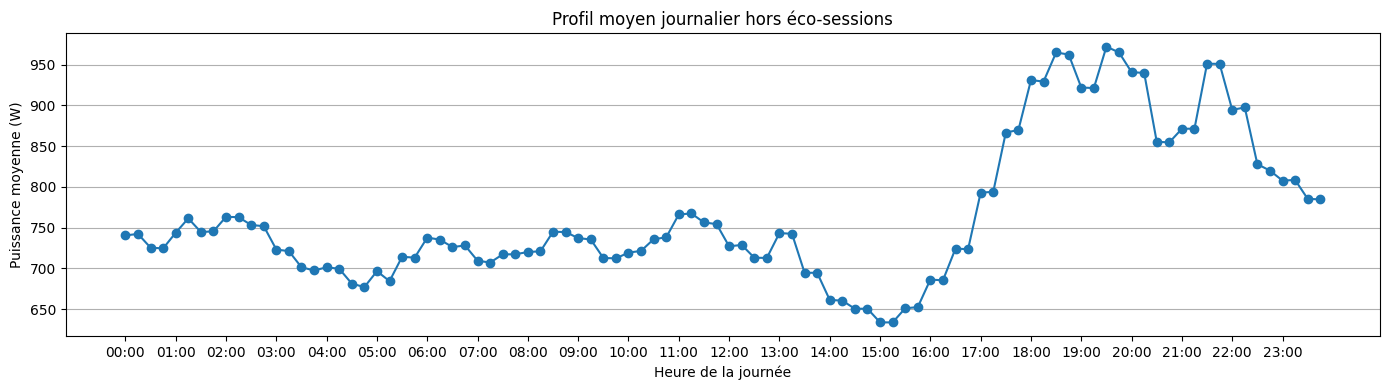

In [145]:
rows = cur.execute("""
SELECT
  strftime('%H:%M', lc.Datetime) AS tod,
  lc.Consumption
FROM LoadCurves lc
LEFT JOIN (
  SELECT DISTINCT date(SessionDatetime) AS d
  FROM CalendarSessions
) es
ON date(lc.Datetime) = es.d
WHERE es.d IS NULL;
""").fetchall()

df = pd.DataFrame(rows, columns=['tod', 'W'])
df['W'] = df['W'].astype(float)

profile = df.groupby('tod')['W'].mean().reindex(
    [f"{h:02d}:{m:02d}" for h in range(24) for m in (0,15,30,45)]
)

x = np.arange(len(profile))
y = profile.to_numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
plt.plot(x, y, marker='o')
plt.xticks(x[::4], [f"{h:02d}:00" for h in range(24)], rotation=0)
plt.xlabel("Heure de la journée")
plt.ylabel("Puissance moyenne (W)")
plt.title("Profil moyen journalier hors éco-sessions")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("consumption_profile.png", dpi=300)
plt.show()


### **Question 2:** Ce profil pourrait servir de référence pour calculer les effacements mais présente plusieurs limites. Quelles sont-elles ? Quelle autre méthode proposerais-tu pour construire cette référence ?

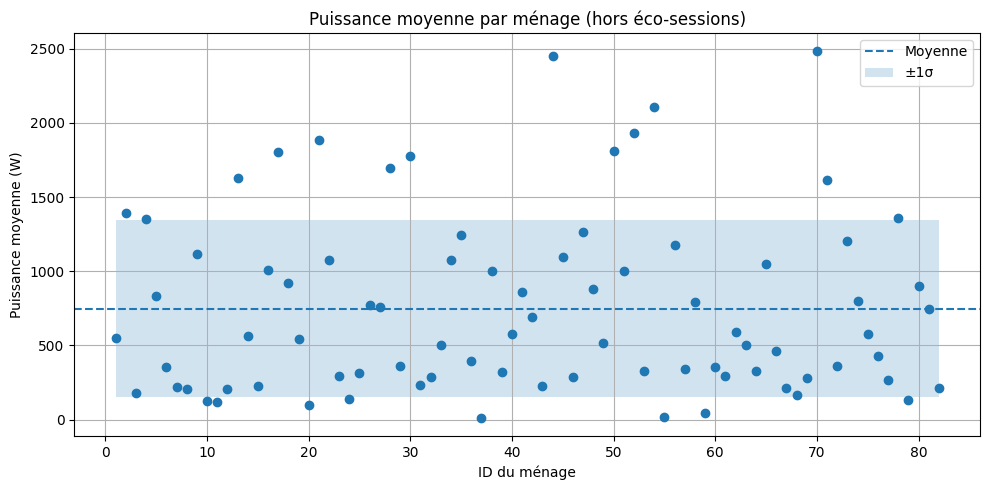

In [146]:
rows = cur.execute("""
SELECT
  lc.HouseholdId,
  strftime('%H:%M', lc.Datetime) AS tod,
  AVG(lc.Consumption) AS avg_W
FROM LoadCurves lc
LEFT JOIN (
  SELECT DISTINCT date(SessionDatetime) AS d
  FROM CalendarSessions
) es ON date(lc.Datetime) = es.d
WHERE es.d IS NULL
GROUP BY lc.HouseholdId, tod
ORDER BY lc.HouseholdId, tod;
""").fetchall()

df = pd.DataFrame(rows, columns=['household_id', 'tod', 'avg_W'])
df['household_id'] = df['household_id'].astype(int)
df['avg_W'] = df['avg_W'].astype(float)

tod_order = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 15, 30, 45)]

baseline_96 = (
    df.pivot(index='household_id', columns='tod', values='avg_W')
      .reindex(columns=tod_order)
)

mean_W_per_household = baseline_96.mean(axis=1)
avg = mean_W_per_household.mean()
std = mean_W_per_household.std()

plt.figure(figsize=(10,5))
plt.plot(mean_W_per_household.index, mean_W_per_household.values, marker='o', linestyle='')
plt.axhline(avg, linestyle='--', label='Moyenne')
plt.fill_between(mean_W_per_household.index, avg-std, avg+std, alpha=0.2, label='±1σ')
plt.xlabel("ID du ménage")
plt.ylabel("Puissance moyenne (W)")
plt.title("Puissance moyenne par ménage (hors éco-sessions)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("avg_power_per_household.png", dpi=300)
plt.show()

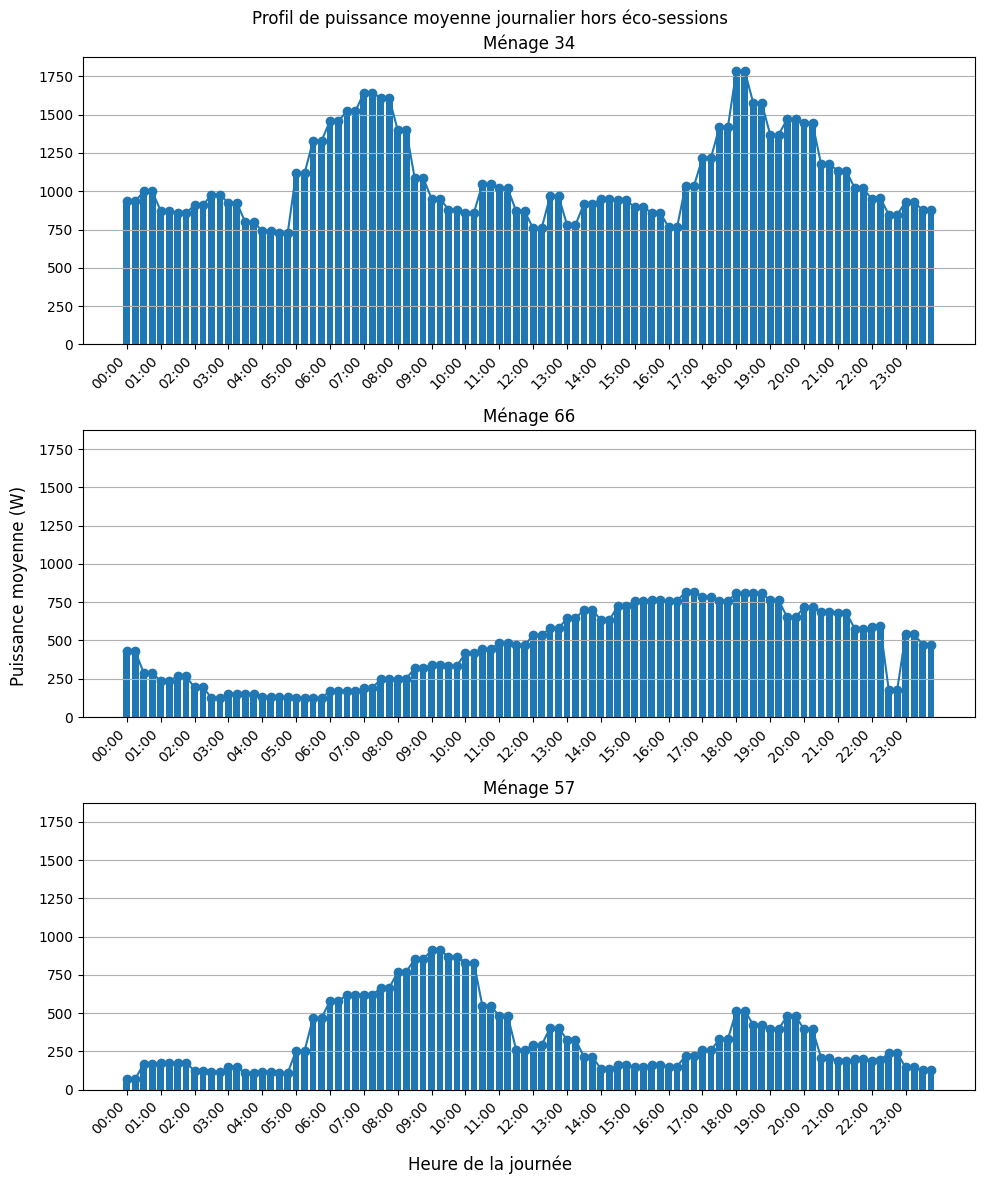

In [156]:
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_households = 3

household_ids = rd.sample(df['household_id'].unique().tolist(), n_households)

tod_order = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 15, 30, 45)]
x = np.arange(96)

fig, axs = plt.subplots(n_households, 1, figsize=(10, 4 * n_households), sharey=True)

if n_households == 1:
    axs = [axs]

for k in range(n_households):
    hid = household_ids[k]

    rows = cur.execute("""
    SELECT
        strftime('%H:%M', lc.Datetime) AS tod,
        lc.Consumption
    FROM LoadCurves lc
    LEFT JOIN (
        SELECT DISTINCT date(SessionDatetime) AS d
        FROM CalendarSessions
    ) AS es
        ON date(lc.Datetime) = es.d
    WHERE es.d IS NULL
      AND lc.HouseholdId = ?;
    """, (hid,)).fetchall()

    df1 = pd.DataFrame(rows, columns=['tod', 'W'])
    df1['W'] = df1['W'].astype(float)

    prof = (
        df1.groupby('tod')['W']
           .mean()
           .reindex(tod_order)
    )

    y = prof.to_numpy()

    axs[k].bar(x, y)
    axs[k].plot(x, y, marker='o')
    axs[k].set_title(f"Ménage {hid}")
    axs[k].grid(axis='y')

    axs[k].set_xticks(x[::4])
    axs[k].set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45, ha='right')

fig.suptitle("Profil de puissance moyenne journalier hors éco-sessions")
fig.supxlabel("Heure de la journée")
fig.supylabel("Puissance moyenne (W)")
plt.tight_layout()
fig.savefig("consumption_profile_for_some_households_96pts.png", dpi=300)
plt.show()


Il y a deux problèmes majeurs :
- Les profiles de consommation ne sont pas tous les mêmes (moyenne journalière biaisée)
- Il y a une grande variance sur la moyenne de consommation selon le foyer

Il faut donc **adapter le profil pour chaque foyer**

In [148]:
daily_mean_load_curves_by_household = {}
consumption_by_household = {}

rows = cur.execute("""
SELECT
    HouseholdId,
    strftime('%H:%M', Datetime) AS tod,
    Consumption
FROM LoadCurves
WHERE date(Datetime) NOT IN (
    SELECT DISTINCT date(SessionDatetime)
    FROM CalendarSessions
);
""").fetchall()

df = pd.DataFrame(rows, columns=['household_id', 'tod', 'consumption'])
df['household_id'] = df['household_id'].astype(int)
df['consumption'] = df['consumption'].astype(float)  # W

# ordre complet des 96 quarts d'heure
tod_order = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 15, 30, 45)]

daily_mean = (
    df.groupby(['household_id', 'tod'])['consumption']
      .mean()
      .unstack()
      .reindex(columns=tod_order)
      .fillna(0.0)
)

daily_mean_load_curves_by_household = {
    hid: daily_mean.loc[hid].to_numpy()
    for hid in daily_mean.index
}


### **Question 3 :** En appliquant la méthode de ton choix, calcule le volume effacé par session pour chaque client participant et au global.

In [149]:
import numpy as np
import pandas as pd

# Participants
participants = cur.execute("""
SELECT DISTINCT HouseholdId
FROM HouseholdParticipation
WHERE HasParticipated = 1;
""").fetchall()
participants = [p[0] for p in participants]

dt_hours = 0.25

gained_volume_per_session_per_participant = {}

for participant in participants:
    if participant not in daily_mean.index:
        continue

    rows = cur.execute("""
    SELECT
        cs.SessionDatetime,
        lc.Datetime,
        lc.Consumption
    FROM (
        SELECT DISTINCT 
            strftime('%H', SessionDatetime) AS hour,
            date(SessionDatetime) AS day,
            SessionDatetime
            FROM CalendarSessions
        ) AS cs
    JOIN
        (
        SELECT
            lc.*,
            strftime('%H', lc.Datetime) AS hour,
            date(lc.Datetime) AS day
            FROM LoadCurves lc
        ) AS lc
      ON cs.hour = lc.hour AND cs.day = lc.day
    WHERE lc.HouseholdId = ?
    ORDER BY cs.SessionDatetime, lc.Datetime;
    """, (participant,)).fetchall()

    if not rows:
        continue

    df_s = pd.DataFrame(rows, columns=["session_dt", "dt", "W_obs"])
    df_s["W_obs"] = df_s["W_obs"].astype(float)

    df_s["tod"] = pd.to_datetime(df_s["dt"]).dt.strftime("%H:%M")

    base_row = daily_mean.loc[participant]
    df_s["W_base"] = df_s["tod"].map(base_row)

    df_s = df_s.dropna(subset=["W_base"])

    df_s["delta_kWh"] = ((df_s["W_obs"] - df_s["W_base"]) / 1000.0) * dt_hours

    per_session = df_s.groupby("session_dt")["delta_kWh"].sum()

    for session_dt, gained_kwh in per_session.items():
        gained_volume_per_session_per_participant.setdefault(session_dt, {})
        gained_volume_per_session_per_participant[session_dt][participant] = float(gained_kwh)

global_per_session = {
    sdt: sum(hh.values())
    for sdt, hh in gained_volume_per_session_per_participant.items()
}

total_global = sum(global_per_session.values())

print("\n--- Global ---")
for sdt, v in sorted(global_per_session.items()):
    print(f"Session {sdt}: {v:.3f} kWh (somme participants)")
print(f"Total global: {total_global:.3f} kWh")
print(global_per_session)



--- Global ---
Session 2025-01-02T08:00:00+01:00: 6.979 kWh (somme participants)
Session 2025-01-02T09:00:00+01:00: 11.593 kWh (somme participants)
Session 2025-01-02T10:00:00+01:00: 11.114 kWh (somme participants)
Session 2025-01-02T11:00:00+01:00: 16.418 kWh (somme participants)
Session 2025-01-02T12:00:00+01:00: 26.424 kWh (somme participants)
Session 2025-01-02T18:00:00+01:00: 18.894 kWh (somme participants)
Session 2025-01-02T19:00:00+01:00: 15.549 kWh (somme participants)
Session 2025-01-03T08:00:00+01:00: 16.782 kWh (somme participants)
Session 2025-01-03T09:00:00+01:00: 21.592 kWh (somme participants)
Session 2025-01-03T10:00:00+01:00: 10.987 kWh (somme participants)
Session 2025-01-03T11:00:00+01:00: 10.370 kWh (somme participants)
Session 2025-01-03T12:00:00+01:00: 10.188 kWh (somme participants)
Session 2025-01-03T18:00:00+01:00: 12.040 kWh (somme participants)
Session 2025-01-03T19:00:00+01:00: 15.502 kWh (somme participants)
Session 2025-01-16T08:00:00+01:00: 7.452 kWh (s

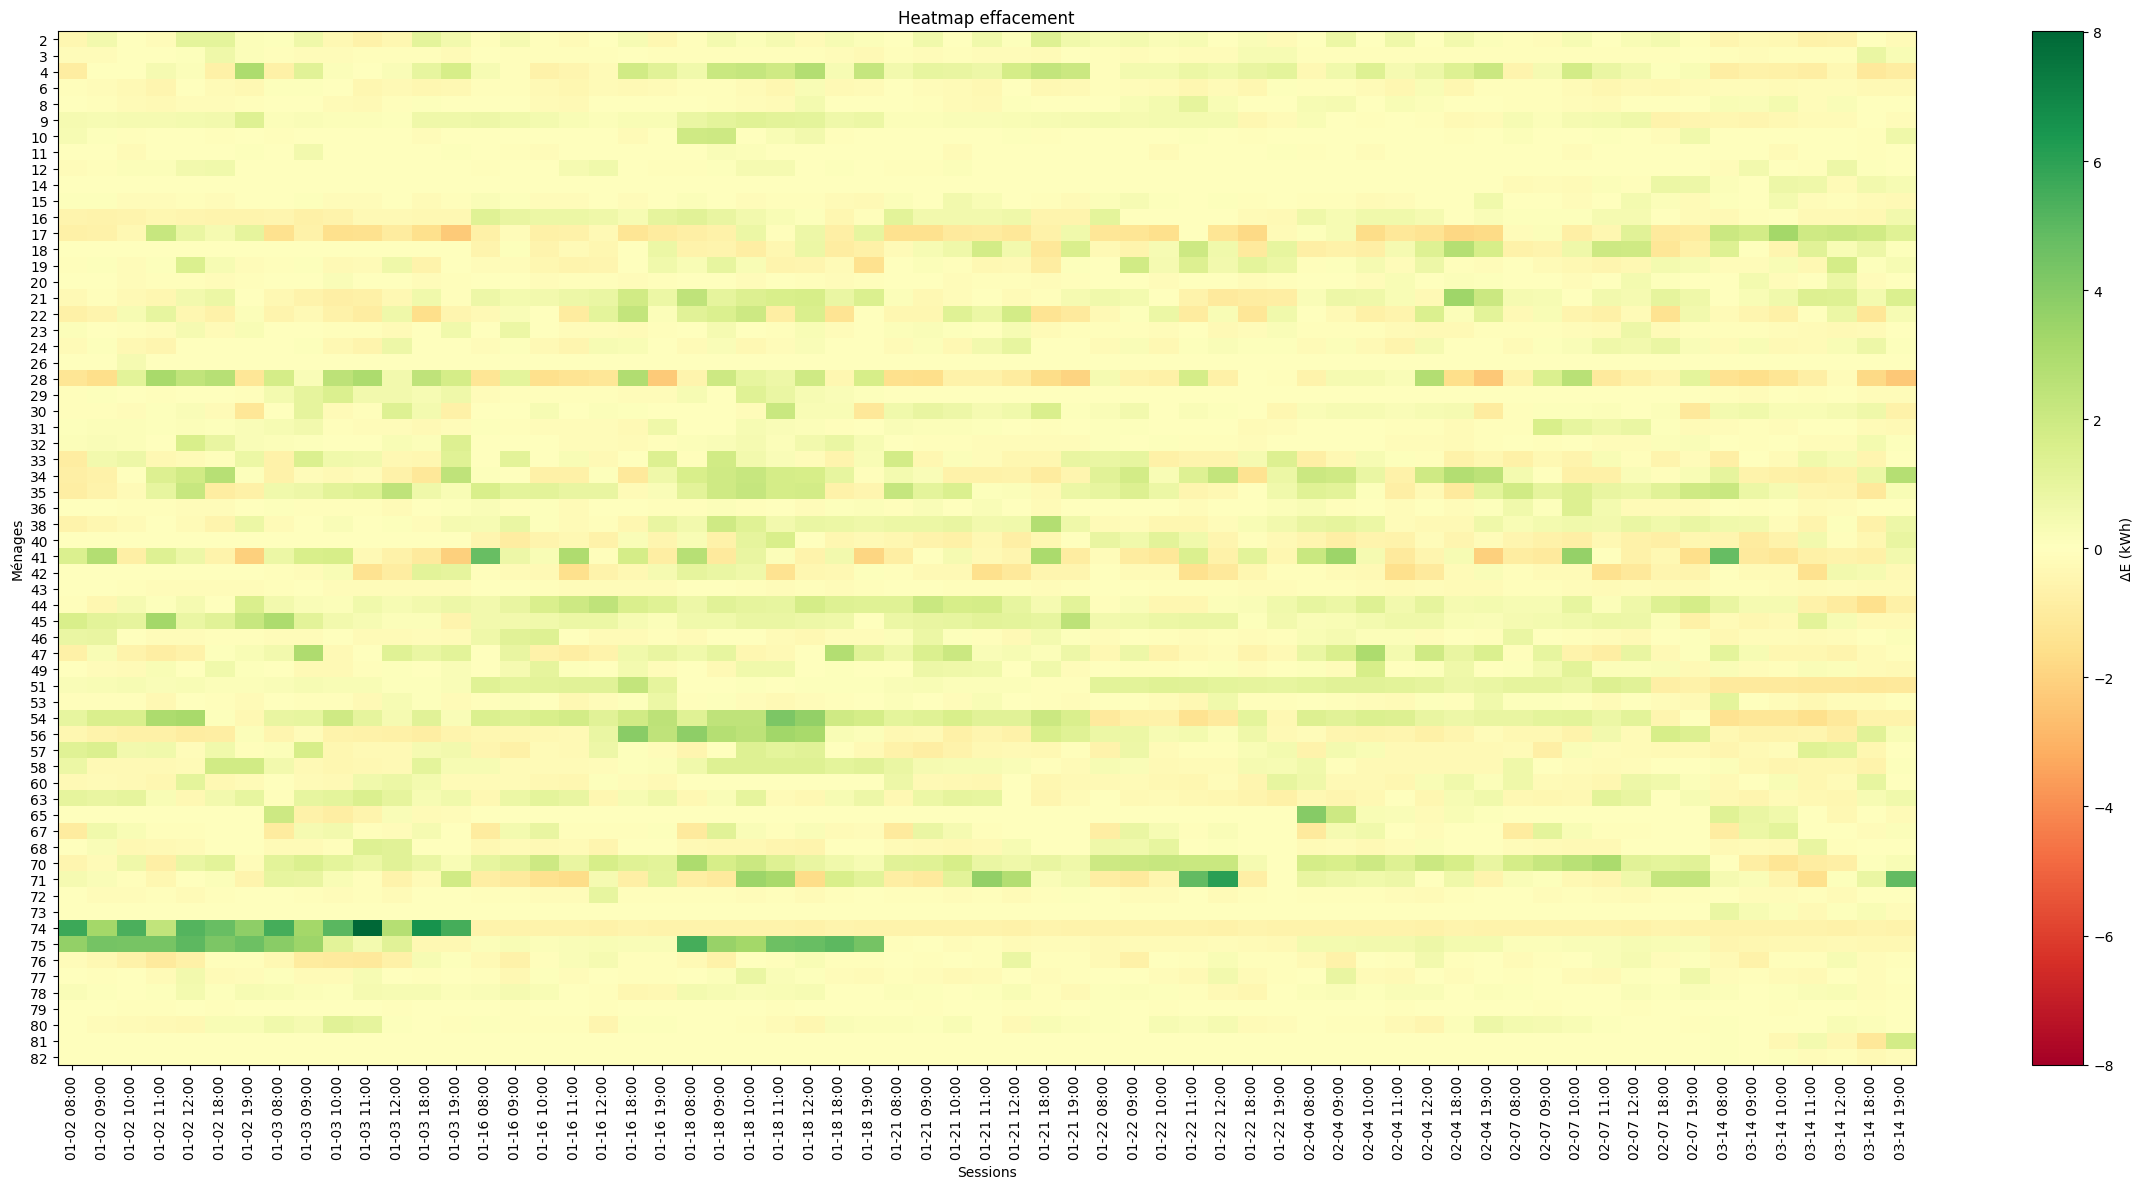

In [150]:
rows = []
for session_dt, per_hh in gained_volume_per_session_per_participant.items():
    for hh, kwh in per_hh.items():
        rows.append((session_dt, hh, kwh))

eff = pd.DataFrame(rows, columns=["session_dt", "household_id", "delta_kWh"])
eff["session_dt"] = pd.to_datetime(eff["session_dt"])


pivot = eff.pivot_table(
    index="household_id", columns="session_dt", values="delta_kWh", aggfunc="sum"
).fillna(0)

plt.figure(figsize=(24,12))
plt.imshow(pivot.values, aspect="auto", cmap="RdYlGn", vmin=-pivot.values.max(), vmax=pivot.values.max())
plt.colorbar(label="ΔE (kWh)")
plt.title("Heatmap effacement")
plt.xlabel("Sessions")
plt.ylabel("Ménages")
plt.xticks(range(pivot.shape[1]), [d.strftime("%m-%d %H:%M") for d in pivot.columns], rotation=90)
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.tight_layout()
plt.savefig("heatmap_effacement.png", dpi=300)
plt.show()


In [152]:
import pandas as pd

n_participants = cur.execute("""
SELECT COUNT(DISTINCT HouseholdId)
FROM HouseholdParticipation
WHERE HasParticipated = 1;
""").fetchone()[0]

def iso_offset(ts):
    ts = pd.to_datetime(ts)
    return ts.strftime("%Y-%m-%dT%H:%M:%S%z")[:-2] + ":" + ts.strftime("%z")[-2:]

earned_price_per_session = {}

for sdt, eff_kwh in global_per_session.items():
    sdt = pd.to_datetime(sdt)
    start = iso_offset(sdt)
    end = iso_offset(sdt + pd.Timedelta(hours=1))

    rows = cur.execute("""
        SELECT PriceDayAhead
        FROM EnergyPrices
        WHERE StartDatetime >= ?
          AND StartDatetime <  ?
        ORDER BY StartDatetime;
    """, (start, end)).fetchall()

    if not rows:
        continue

    avg_price = sum(float(r[0]) for r in rows) / len(rows)
    earned_price_per_session[sdt] = (eff_kwh / 1000.0) * (avg_price - n_participants*0.13/1000)

print("\nGains estimés par session")
total_earned = 0.0
for sdt, earned in sorted(earned_price_per_session.items()):
    print(f"Session {sdt}: {earned:.2f} €")
    total_earned += earned
print(f"Total estimé: {total_earned:.2f} €")


Gains estimés par session
Session 2025-01-02 08:00:00+01:00: 0.95 €
Session 2025-01-02 09:00:00+01:00: 1.50 €
Session 2025-01-02 10:00:00+01:00: 1.40 €
Session 2025-01-02 11:00:00+01:00: 2.06 €
Session 2025-01-02 12:00:00+01:00: 3.15 €
Session 2025-01-02 18:00:00+01:00: 2.77 €
Session 2025-01-02 19:00:00+01:00: 2.03 €
Session 2025-01-03 08:00:00+01:00: 2.23 €
Session 2025-01-03 09:00:00+01:00: 2.82 €
Session 2025-01-03 10:00:00+01:00: 1.35 €
Session 2025-01-03 11:00:00+01:00: 1.18 €
Session 2025-01-03 12:00:00+01:00: 1.10 €
Session 2025-01-03 18:00:00+01:00: 1.70 €
Session 2025-01-03 19:00:00+01:00: 2.06 €
Session 2025-01-16 08:00:00+01:00: 1.30 €
Session 2025-01-16 09:00:00+01:00: 1.73 €
Session 2025-01-16 10:00:00+01:00: 0.55 €
Session 2025-01-16 11:00:00+01:00: -0.10 €
Session 2025-01-16 12:00:00+01:00: 0.86 €
Session 2025-01-16 18:00:00+01:00: 3.16 €
Session 2025-01-16 19:00:00+01:00: 2.15 €
Session 2025-01-18 08:00:00+01:00: 3.70 €
Session 2025-01-18 09:00:00+01:00: 4.19 €
Sessio